In [1]:
import os
import sys
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# -------------- NESTED PATH CORRECTION -------------------------------- #

# For all script files, we add the parent directory to the system path
cwd = re.sub(r"[\\]", "/", os.getcwd())
cwd_list = cwd.split("/")
path = sys.argv[0]
path_list = path.split("/")
# either the entire filepath is entered as command i python
if cwd_list[0:3] == path_list[0:3]:
    full_path = path
# or a relative path is entered, in which case we append the path to the cwd_path
else:
    full_path = cwd + "/" + path
# remove the overlap
root_dir = re.search(r"(^.+python_road_upgrades)", full_path).group(1)
sys.path.append(root_dir)

# ---------------------------------------------------------------------- #

# Determining the threshold of the heuristic model

## 1.1. Import the Data Sets

In [16]:
# first the manual visual identifications (true values)
visual = pd.read_excel(f'{root_dir}/Imports/visual_classification_2020_2021_05_07.xlsx').set_index(['road_id', 'subroad_id'])
visual[visual['upgrade'] != 1] = 0  # replace unclear and NaN with 0

# followed by the analysis data
def import_analysis(data_fp):
    data = pd.read_excel(data_fp,  header=[0,1], index_col=[0]).set_index(
        [('road_id', 'Unnamed: 1_level_1'), ('subroad_id', 'Unnamed: 2_level_1')])
    data.index.names = ['road_id', "subroad_id"]
    data.columns.names = [None, None]
    data = data.drop([('upgrade', 'bright_B4_diff'), ('upgrade', 'bright_B4')], axis=1)
    return data

data_fp = f"{root_dir}/Imports/analysis_2020_2021_05_07_pct_40.xlsx" # a copy taken from Exports/Roads/composites2
#data_fp = f"{root_dir}/Imports/analysis_2020_2021_05_07_pct_30.xlsx" # a copy taken from Exports/Roads/composites2
data = import_analysis(data_fp)

print(data.columns)
# 1.2 Split the data into training and test sets
def get_regressors(df):
    return df[[
        ('B4_min', 'road_id'),
        ('B4_min', 'left_avg'),
        ('B4_min', 'right_avg'),
        #('B4_mean', 'road_id'),
        #('B4_mean', 'left_avg'),
        #('B4_mean', 'right_avg'),
        ('B4_min', 'dist_median'),
        ('B4_min', 'dist_mean'),
        ('B4_min', 'share'),
        ('B4_diff_factor', 'road_id')

    ]]

X = get_regressors(data)
y = visual['upgrade'].astype('int')  # Labels


MultiIndex([(        'B4_max',       'road_id'),
            (        'B4_max',      'left_avg'),
            (        'B4_max',     'right_avg'),
            (        'B4_max',      'road_upg'),
            (        'B4_max',  'left_avg_upg'),
            (        'B4_max', 'right_avg_upg'),
            (        'B4_max',   'dist_median'),
            (        'B4_max',     'dist_mean'),
            (        'B4_max',         'share'),
            (        'B4_min',       'road_id'),
            (        'B4_min',      'left_avg'),
            (        'B4_min',     'right_avg'),
            (        'B4_min',      'road_upg'),
            (        'B4_min',  'left_avg_upg'),
            (        'B4_min', 'right_avg_upg'),
            (        'B4_min',   'dist_median'),
            (        'B4_min',     'dist_mean'),
            (        'B4_min',         'share'),
            (       'B4_mean',       'road_id'),
            (       'B4_mean',      'left_avg'),
            (       

What is the average side values?

<ipython-input-9-47ea91ef91b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[('', 'upgraded')] = y


left avg count    150.000000
mean       0.098243
std        0.224732
min       -0.787582
25%       -0.016394
50%        0.091331
75%        0.219828
max        0.728815
dtype: float64
right avg count    101.000000
mean       0.415828
std        0.445289
min       -0.465228
25%        0.134915
50%        0.341264
75%        0.617361
max        1.919961
dtype: float64


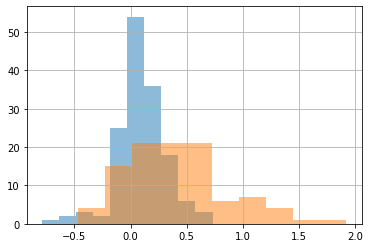

In [9]:
import matplotlib.pyplot as plt
df = X
df[('', 'upgraded')] = y

df = df.loc[((df[('B4_min', 'road_id')] <= -50) | (df[('B4_min', 'road_id')] >= 50)), :]

df_u = df.loc[(df[("", "upgraded")] == 1), :]
df_n = df.loc[(df[("", "upgraded")] == 0), :]

left_avg_pct_u = df_u[('B4_min', 'left_avg')]/df_u[('B4_min', 'road_id')]
right_avg_pct_u = df_u[('B4_min', 'right_avg')]/df_u[('B4_min', 'road_id')]
avg_pct_u = 0.5 * (left_avg_pct_u + right_avg_pct_u)

left_avg_pct_n = df_n[('B4_min', 'left_avg')]/df_n[('B4_min', 'road_id')]
right_avg_pct_n = df_n[('B4_min', 'right_avg')]/df_n[('B4_min', 'road_id')]
avg_pct_n = 0.5 * (left_avg_pct_n + right_avg_pct_n)

print("left avg", avg_pct_u.describe())
print("right avg", avg_pct_n.describe())


#left_avg_pct.hist()
#right_avg_pct.hist()
#avg_pct_u.plot(kind='hist', density=True)
avg_pct_u.hist(alpha=0.5)
avg_pct_n.hist(alpha=0.5)
plt.show()
#plt.show()



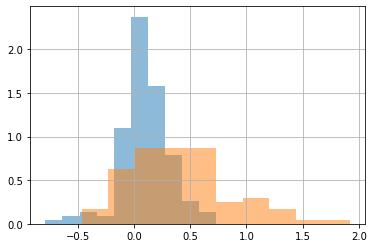

In [4]:
avg_pct_u.hist(density=True, alpha=0.5)
avg_pct_n.hist(density=True, alpha=0.5)
plt.show()

In [51]:
# export the DF

df_e = pd.DataFrame({'avg_upgraded': avg_pct_u, 'avg_not_upgraded': avg_pct_n})
df_e.reset_index().to_excel('average_histogram.xlsx', index=False)

In [3]:
# X[('', 'upgraded')] = y
#
# upgraded_roads = X.loc[X[("", "upgraded")] == 1, :]
# other_roads = X.loc[X[("", "upgraded")] != 1, :]
# upgraded_roads

In [4]:
# What is the average B4_min on the road for upgraded vs not upgraded
#
# upg_mean = upgraded_roads[('B4_min', 'road_id')].mean()
# print(upg_mean)
#
# upg_other = other_roads[('B4_min', 'road_id')].mean()
# print(upg_other)

Exploring Heuristics

In [20]:
from sklearn.utils import check_random_state

# check for NaN and drop
nan_index = X[X.isnull().any(1)].index
X = X.drop(nan_index, axis=0)
y = y.drop(nan_index, axis=0)

# Split dataset into training set and test set
#     - argument test_size = 0.3: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5350)



## HERE WE SAY THAT HEUERISTIC IS THE CASE WHERE THERE ARE
# h_pred = (
#     (X_test[('B4_min', 'road_id')] < 0) &
#     (X_test[('B4_min', 'left_avg')] > 0.75 * X_test[('B4_min', 'road_id')]) &
#     (X_test[('B4_min', 'right_avg')] > 0.75 * X_test[('B4_min', 'road_id')]) #&
#     #(X_test[('B4_min', 'left_avg')] > X_test[('B4_min', 'road_id')] + 20) &
#     #(X_test[('B4_min', 'right_avg')] > X_test[('B4_min', 'road_id')] + 20)
#          ).astype('int')

# compute the optimal share threshold for the training data
accuracy_dic = {}
for t in range(0, 101):
    share = t/100
    h_pred = (
        (X_train[('B4_min', 'share')] > share)
    ).astype('int')
    a = metrics.accuracy_score(y_train, h_pred)
    if a not in list(accuracy_dic.keys()):
        accuracy_dic[a] = [share]
    else:
        accuracy_dic[a].append(share)

max_key = max(list(accuracy_dic.keys()))
print("MAX ACCURACY IS", max_key)
print("THRESH IS", accuracy_dic[max_key])

h_pred_share_test = (
    (X_test[('B4_min', 'share')] > accuracy_dic[max_key][0])
).astype('int')


print("Heuristic Model Accuracy:", metrics.accuracy_score(y_test, h_pred_share_test))
#print("Random Forest Model Accuracy:", metrics.accuracy_score(y_test, h_pred))


#exit()

MAX ACCURACY IS 0.9359605911330049
THRESH IS [0.28]
Heuristic Model Accuracy: 0.9130434782608695
